In [7]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Paths, RIS, r_hat, normalize
from sionna import PI

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement


In [9]:
# Load integrated scene
scene = load_scene("oulu_downtown_scene/untitled.xml") # Try also sionna.rt.scene.etoile
ris_flag = True

#scene.render(camera="scene-cam-0")
for i, obj in enumerate(scene.objects.values()):
    print(f"{obj.name} : {obj.radio_material.name}")
    #if i >=10:
    break

    
scene.tx_array = PlanarArray(num_rows = 4,
                            num_cols = 4,
                            vertical_spacing = 0.5,
                            horizontal_spacing = 0.5,
                            pattern="tr38901",
                            polarization="V")

scene.rx_array = PlanarArray(num_rows = 1,
                            num_cols = 1,
                            vertical_spacing = 0.5,
                            horizontal_spacing = 0.5,
                            pattern="iso",
                            polarization="V")

tx = Transmitter("tx", [-55.5771,-93.9931,50], [0.0, 0.0, 0,0]) # name, position, orientation
#rx_1  = Receiver("rx",[-12.8551,89.634,1],[0.0,0.0,0.0])
#rx_2  = Receiver("rx",[-102.324,-67.0766,1],[0.0,0.0,0.0])
#rx_3  = Receiver("rx",[-70.1005,81.2548,2],[0.0,0.0,0.0])
rx  = Receiver("rx",[58,121,10],[0.0,0.0,0.0])

#63.2532 m , 130.59 m,10.0726 m

scene.add(tx)
scene.add(rx)

# Define RIS dimensions
height = 16  # RIS height in meters
width = 40   # RIS width in meters
#width = 53   # RIS width in meters

# Compute the number of elements based on half-wavelength spacing
wavelength = scene.wavelength  # Compute wavelength from scene frequency
num_rows_ris = int(height / (0.5 * wavelength))  # Vertical elements
num_cols_ris = int(width / (0.5 * wavelength))   # Horizontal elements

if ris_flag:
    # Configure RIS positioned on a vertical wall
    ris = RIS(
        name="ris",
        #position=[-103.663, 83.4765, 8.89431],  # Centered at 8m height
        #position=[-39.5144, 112.261, 8.9532],  # Centered at 8m height
        position=[-45.6919, 49.755,15.8209],  # Centered at 8m height
        #orientation=[PI/2,-2.1293,0],  # Vertical RIS in the y-z plane
        #orientation=[PI/3.2,0,0],  # Vertical RIS in the y-z plane
        num_rows=50,
        num_cols=50,
        look_at=(tx.position+rx.position)/2
    )
    scene.add(ris)
    cm = scene.coverage_map(max_depth=20,los=True,ris=True)
                       
else:
    cm = scene.coverage_map(max_depth=20,
                        los=True,
                        ris=False)

path = scene.compute_paths(ris=False, los=False,max_depth=20,)
scene.preview(paths=path)

Autosaari-itu_marble : itu_marble


Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [13]:
a, tau = path.cir()
#print(a.shape)
#print(tau.shape)
a[0,0,0,0,0,:,0]
tau[0,0,0,:]

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([2.7037458e-07, 0.0000000e+00, 1.3101612e-08,           nan],
      dtype=float32)>

(1, 1, 1, 1, 16, 4, 1)
(1, 1, 1, 4)


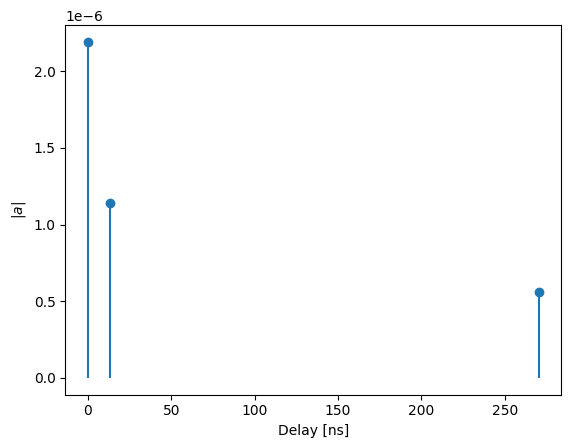

In [16]:
a, tau = path.cir()
print(a.shape)
print(tau.shape)
plt.figure()
plt.stem(tau[0,0,0,:]*1e9, np.abs(a[0,0,0,0,0,:,0]))
plt.xlabel("Delay [ns]")
plt.ylabel(r"$|a|$");
plt.savefig("delay_profile.png", dpi=300, bbox_inches='tight')


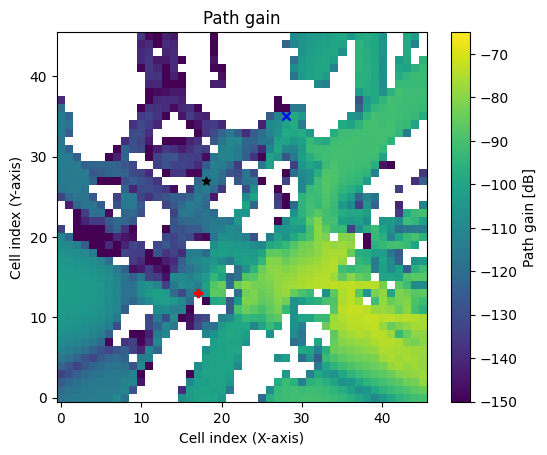

In [19]:
scene.preview(paths=path, coverage_map=cm)
cm.show(vmax=-65, vmin=-150, show_ris=True, show_rx=True);